**Question:"Which signals had the best average long-short returns from 2008 to 2023?"**

**Step 1: Loading in Data**

In [1]:
#Set-Up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Loading the data
ls_returns = pd.read_csv("https://github.com/aaiken1/fin-data-analysis-python/raw/main/data/PredictorLSretWide.csv")

In [4]:
# Checking the data
ls_returns.head()

,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
0,1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-13.686393,NaN,NaN,NaN,NaN,NaN,NaN
1,1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-5.135248,NaN,NaN,NaN,NaN,NaN,NaN
2,1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.832534,NaN,NaN,NaN,NaN,NaN,NaN
3,1926-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.440934,NaN,NaN,NaN,NaN,NaN,NaN
4,1926-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.483265,NaN,NaN,NaN,NaN,NaN,NaN


**Step 2: Clean and Preprocess Data**

In [5]:
# Convert date column to datetime
ls_returns['date'] = pd.to_datetime(ls_returns['date'])

In [6]:
# Filter for 2008-2023 period
ls_returns = ls_returns[(ls_returns['date'] >= '2008-01-01') & (ls_returns['date'] <= '2023-12-31')]
print(f"Dataset shape after filtering to 2008-2023: {ls_returns.shape}")
print(f"Date range: {ls_returns['date'].min()} to {ls_returns['date'].max()}")

Dataset shape after filtering to 2008-2023: (180, 213)
Date range: 2008-01-31 00:00:00 to 2022-12-30 00:00:00


In [7]:
# Set date as index
ls_returns_indexed = ls_returns.set_index('date')

In [8]:
#Cheicking for missing values
missing_values = ls_returns_indexed.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 1165


In [9]:
# Get descriptive statistics for each signal
print("\nCalculating summary statistics...")


Calculating summary statistics...


In [10]:
# First, let's check the data range and look for outliers
print("Checking data range for potential issues...")
print(f"Data range - Min: {ls_returns_indexed.min().min()}, Max: {ls_returns_indexed.max().max()}")

Checking data range for potential issues...
Data range - Min: -166.058978627311, Max: 321.296962723136


In [11]:
# Calculate annualized metrics
monthly_mean = ls_returns_indexed.mean()
monthly_std = ls_returns_indexed.std()

In [12]:
# Check if returns are already in decimal form (e.g., 0.05 for 5%) or percentage form
if ls_returns_indexed.abs().max().max() > 10:  # Likely percentage form
    print("Data appears to be in percentage form. Converting to decimal form...")
    ls_returns_decimal = ls_returns_indexed / 100
    monthly_mean = ls_returns_decimal.mean()
    monthly_std = ls_returns_decimal.std()
else:
    ls_returns_decimal = ls_returns_indexed

Data appears to be in percentage form. Converting to decimal form...


In [13]:
# Handle division by zero for Sharpe ratio
monthly_sharpe = monthly_mean.copy()
valid_std = monthly_std > 0  # Only calculate Sharpe where std > 0
monthly_sharpe[valid_std] = monthly_mean[valid_std] / monthly_std[valid_std]
monthly_sharpe[~valid_std] = np.nan

In [14]:
# Annualize metrics - checking for reasonable values
# If returns are monthly, we compound them
annualized_mean = ((1 + monthly_mean) ** 12) - 1
annualized_std = monthly_std * np.sqrt(12)

In [15]:
# Check for extreme values that might indicate calculation errors
extreme_returns = annualized_mean[annualized_mean.abs() > 10]  # More than 1000% return
if not extreme_returns.empty:
    print(f"Warning: Found {len(extreme_returns)} signals with extreme annualized returns (>1000%):")
    print(extreme_returns.head())
    
    # Recalculate using simple annualization if extreme values detected
    print("Recalculating with simple annualization (monthly * 12)...")
    annualized_mean = monthly_mean * 12
    annualized_std = monthly_std * np.sqrt(12)

In [16]:
# Calculate Sharpe ratio (using annualized figures)
annualized_sharpe = annualized_mean.copy()
valid_ann_std = annualized_std > 0
annualized_sharpe[valid_ann_std] = annualized_mean[valid_ann_std] / annualized_std[valid_ann_std]
annualized_sharpe[~valid_ann_std] = np.nan

In [17]:
# Create summary DataFrame
summary_stats = pd.DataFrame({
    'Monthly_Mean': monthly_mean,
    'Monthly_Std': monthly_std,
    'Monthly_Sharpe': monthly_sharpe,
    'Ann_Return': annualized_mean,
    'Ann_Volatility': annualized_std,
    'Ann_Sharpe': annualized_sharpe
})

In [18]:
# Remove signals with missing Sharpe ratios before sorting
summary_stats_clean = summary_stats.dropna(subset=['Ann_Sharpe'])

In [19]:
# Sort by annualized Sharpe ratio
summary_stats_sorted = summary_stats_clean.sort_values('Ann_Sharpe', ascending=False)

In [20]:
# Display top 10 signals by Sharpe ratio
print("Top 10 signals by Sharpe ratio (excluding signals with insufficient data):")
print(summary_stats_sorted.head(10))

Top 10 signals by Sharpe ratio (excluding signals with insufficient data):
                    Monthly_Mean  Monthly_Std  Monthly_Sharpe  Ann_Return  \
SmileSlope              0.010005     0.018434        0.542743    0.126892   
PatentsRD               0.006693     0.016957        0.394728    0.083343   
AnnouncementReturn      0.007653     0.019501        0.392419    0.095798   
EarningsStreak          0.006100     0.018722        0.325818    0.075707   
DivSeason               0.001631     0.005419        0.300908    0.019744   
RIO_Volatility          0.011908     0.044593        0.267041    0.152639   
ShareIss1Y              0.009045     0.033341        0.271280    0.114104   
NetPayoutYield          0.013947     0.056038        0.248879    0.180813   
ExchSwitch              0.011400     0.045882        0.248473    0.145718   
VolumeTrend             0.005007     0.020036        0.249892    0.061764   

                    Ann_Volatility  Ann_Sharpe  
SmileSlope                0.

In [21]:
# Display bottom 10 signals by Sharpe ratio
print("Bottom 10 signals by Sharpe ratio (excluding signals with insufficient data):")
print(summary_stats_sorted.tail(10))

Bottom 10 signals by Sharpe ratio (excluding signals with insufficient data):
                    Monthly_Mean  Monthly_Std  Monthly_Sharpe  Ann_Return  \
GrSaleToGrInv          -0.001137     0.014266       -0.079692   -0.013558   
FirmAge                -0.002500     0.031034       -0.080541   -0.029585   
EquityDuration         -0.003125     0.036405       -0.085836   -0.036861   
BetaLiquidityPS        -0.003094     0.034643       -0.089317   -0.036505   
GrSaleToGrOverhead     -0.001778     0.018959       -0.093756   -0.021123   
Herf                   -0.002544     0.026228       -0.097012   -0.030110   
FR                     -0.004912     0.044781       -0.109683   -0.057374   
HerfBE                 -0.003277     0.024705       -0.132661   -0.038627   
HerfAsset              -0.003657     0.026204       -0.139563   -0.043014   
dCPVolSpread           -0.005810     0.018783       -0.309349   -0.067540   

                    Ann_Volatility  Ann_Sharpe  
GrSaleToGrInv            

In [22]:
# Also show signals that couldn't be analyzed
missing_sharpe = summary_stats[summary_stats['Ann_Sharpe'].isna()]
if not missing_sharpe.empty:
    print(f"Signals with insufficient data for Sharpe ratio calculation ({len(missing_sharpe)} total):")
    print(missing_sharpe)

Signals with insufficient data for Sharpe ratio calculation (3 total):
            Monthly_Mean  Monthly_Std  Monthly_Sharpe  Ann_Return  \
Activism1            NaN          NaN             NaN         NaN   
Activism2            NaN          NaN             NaN         NaN   
Governance           NaN          NaN             NaN         NaN   

            Ann_Volatility  Ann_Sharpe  
Activism1              NaN         NaN  
Activism2              NaN         NaN  
Governance             NaN         NaN  


**Step 3: Visualization**

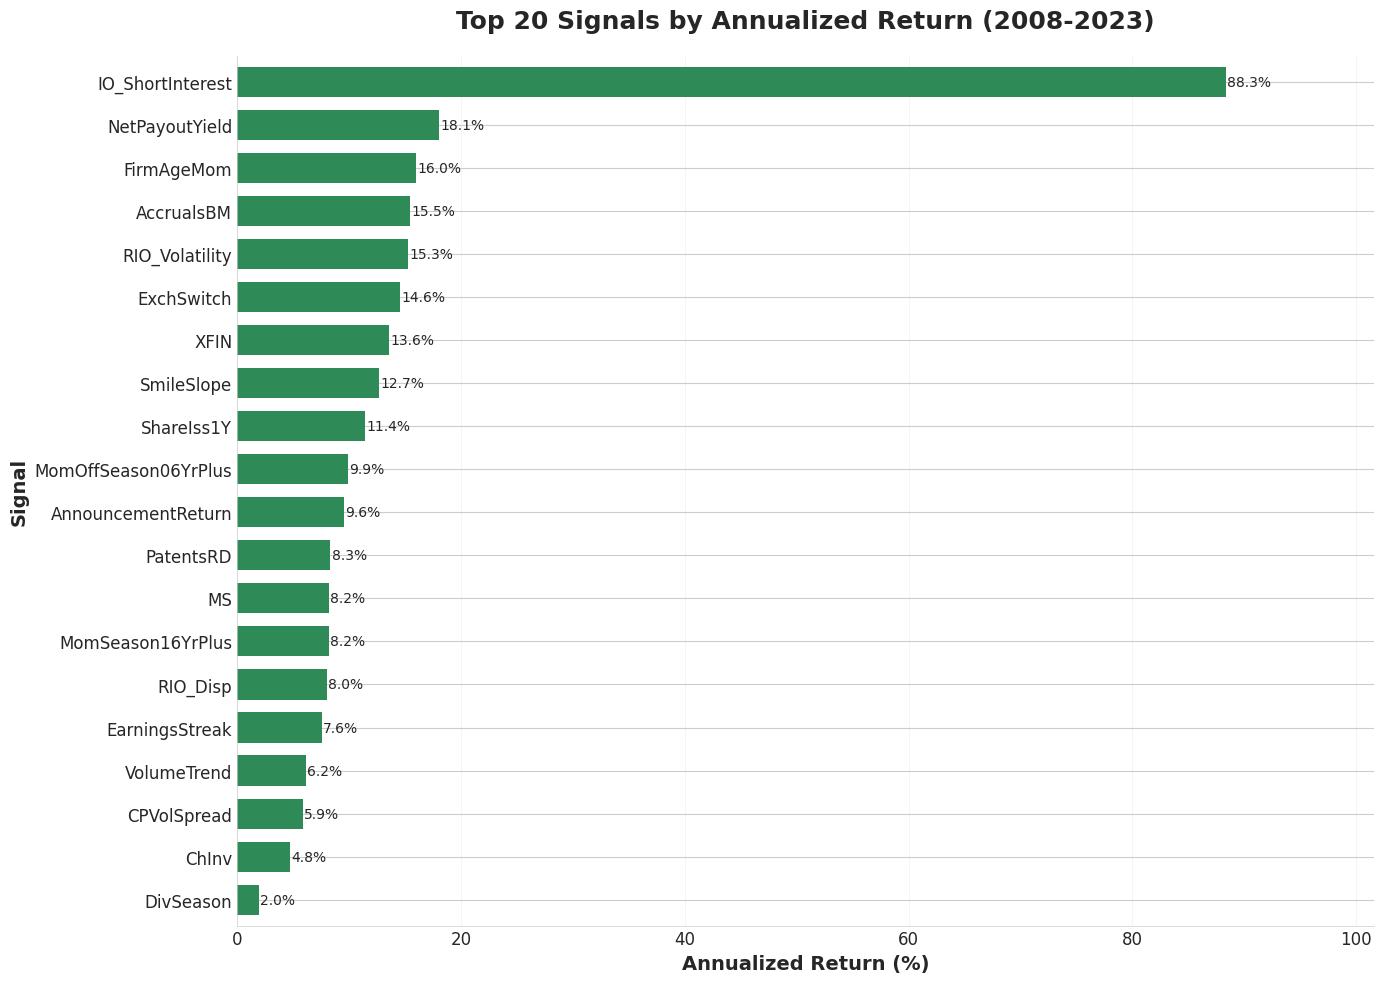

In [23]:
# 3.1 Bar chart of top 20 signals by annualized return
plt.figure(figsize=(14, 10))

# Get top 20 returns and convert to percentage
top_20_returns = summary_stats_sorted['Ann_Return'].head(20) * 100  

# Check for extreme values and handle them
if top_20_returns.max() > 1000:  # More than 1000%
    print(f"Warning: Extreme values detected in returns. Max value: {top_20_returns.max()}")
    # Cap values at a reasonable maximum for visualization
    top_20_returns = top_20_returns.clip(upper=100)  # Cap at 100%

# Sort from highest to lowest for display
top_20_returns_sorted = top_20_returns.sort_values(ascending=True)

# Create the bar chart with enhanced styling
ax = top_20_returns_sorted.plot(kind='barh', color='#2E8B57', width=0.7)

# Customize the plot
plt.title('Top 20 Signals by Annualized Return (2008-2023)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Annualized Return (%)', fontsize=14, fontweight='bold')
plt.ylabel('Signal', fontsize=14, fontweight='bold')

# Add grid only on x-axis with custom style
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels on the bars
for i, v in enumerate(top_20_returns_sorted):
    if v < 1000:  # Only show reasonable values
        ax.text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=10)
    else:
        ax.text(5, i, 'Extreme', va='center', fontsize=10, color='red')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set reasonable x-axis limits
max_value = min(top_20_returns_sorted.max(), 100)  # Cap at 100% for readability
ax.set_xlim(0, max_value * 1.15)

# Adjust layout
plt.tight_layout()
plt.show()  # Display directly in notebook instead of saving

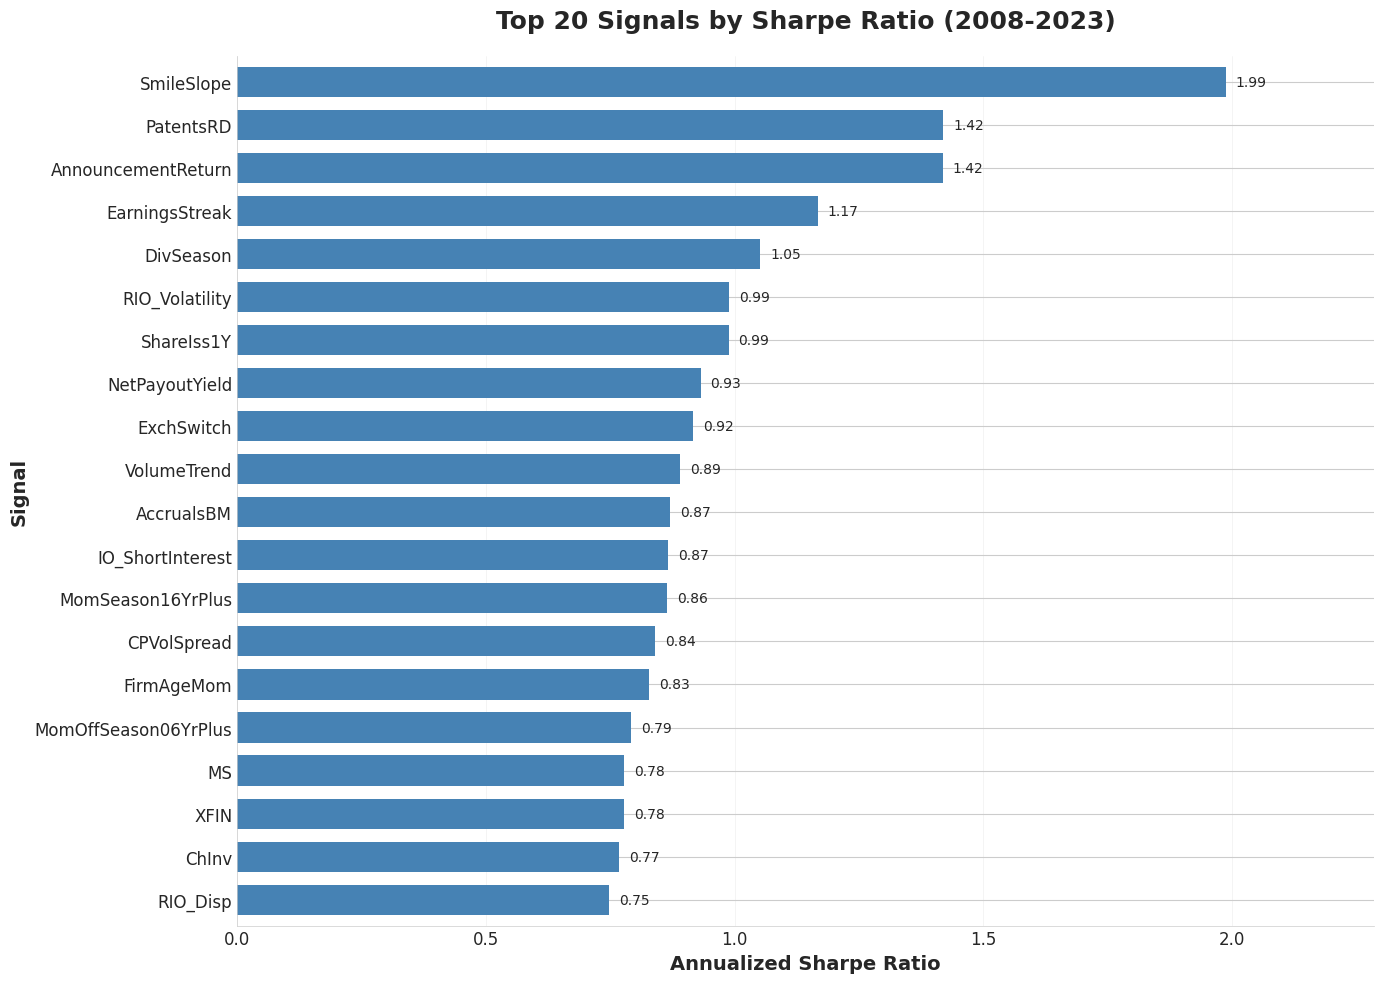

In [24]:
# 3.2 Bar chart of top 20 signals by Sharpe ratio
plt.figure(figsize=(14, 10))

# Get top 20 Sharpe ratios
top_20_sharpe = summary_stats_sorted['Ann_Sharpe'].head(20)

# Check for extreme values
if top_20_sharpe.max() > 10:  # Sharpe ratios above 10 are extremely rare
    print(f"Warning: Extreme Sharpe ratios detected. Max value: {top_20_sharpe.max()}")
    # Cap at a reasonable maximum
    top_20_sharpe = top_20_sharpe.clip(upper=10)

top_20_sharpe_sorted = top_20_sharpe.sort_values(ascending=True)

# Create the bar chart
ax = top_20_sharpe_sorted.plot(kind='barh', color='#4682B4', width=0.7)

# Customize the plot
plt.title('Top 20 Signals by Sharpe Ratio (2008-2023)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Annualized Sharpe Ratio', fontsize=14, fontweight='bold')
plt.ylabel('Signal', fontsize=14, fontweight='bold')

# Add grid only on x-axis
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add value labels on the bars
for i, v in enumerate(top_20_sharpe_sorted):
    if v < 10:
        ax.text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=10)
    else:
        ax.text(0.5, i, 'Extreme', va='center', fontsize=10, color='red')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set reasonable x-axis limits
max_value = min(top_20_sharpe_sorted.max(), 5)  # Cap at 5 for readability
ax.set_xlim(0, max_value * 1.15)

# Adjust layout
plt.tight_layout()
plt.show()  # Display directly in notebook instead of saving

Creating cumulative returns plot for top 5 signals...
Top 5 signals by Sharpe ratio: ['SmileSlope', 'PatentsRD', 'AnnouncementReturn', 'EarningsStreak', 'DivSeason']
Converting SmileSlope from percentage to decimal form
Signal SmileSlope: Start value=1, End value=5.83
Converting PatentsRD from percentage to decimal form
Signal PatentsRD: Start value=1, End value=1.04
Converting AnnouncementReturn from percentage to decimal form
Signal AnnouncementReturn: Start value=1, End value=3.81
Converting EarningsStreak from percentage to decimal form
Signal EarningsStreak: Start value=1, End value=2.90
Converting DivSeason from percentage to decimal form
Signal DivSeason: Start value=1, End value=1.34


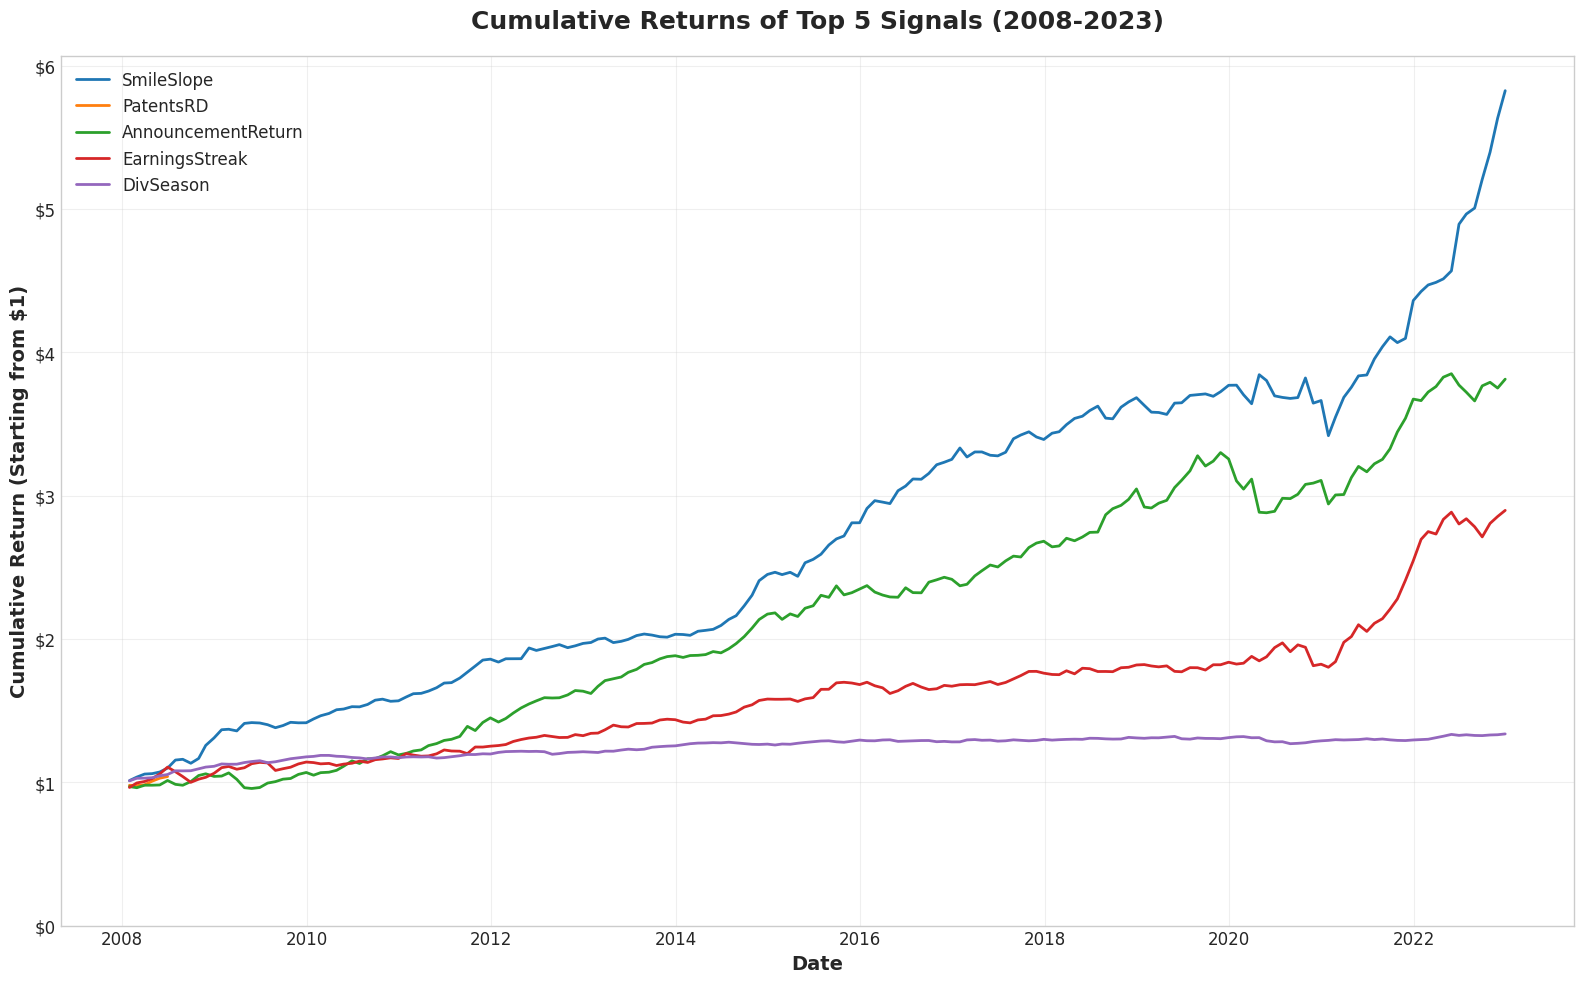

In [25]:
# 3.3 Time series of cumulative returns for top 5 signals
print("Creating cumulative returns plot for top 5 signals...")
top_5_signals = summary_stats_sorted.index[:5]

print(f"Top 5 signals by Sharpe ratio: {list(top_5_signals)}")

# Initialize figure
fig, ax = plt.subplots(figsize=(16, 10))

# Define color palette for better visibility
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot each signal separately
for idx, signal in enumerate(top_5_signals):
    # Get the data for this signal
    signal_data = ls_returns[['date', signal]].copy()
    
    # Drop rows with NaN for this specific signal
    signal_data = signal_data.dropna()
    
    if len(signal_data) > 0:  # Only proceed if we have data
        # Sort by date to ensure proper cumulative calculation
        signal_data = signal_data.sort_values('date')
        
        # Convert to decimal form if needed
        returns = signal_data[signal].values
        
        # Detect if returns are in percentage form
        if np.abs(returns).max() > 2:  # Returns > 200% monthly are suspicious
            print(f"Converting {signal} from percentage to decimal form")
            returns = returns / 100  # Convert from percentage to decimal
        
        # Additional check for extremely large values
        if np.abs(returns).max() > 1:  # Monthly returns > 100% are still very high
            print(f"WARNING: {signal} has extreme values. Max return: {np.abs(returns).max():.2f}")
            # Cap extreme values for visualization
            returns = np.clip(returns, -0.5, 0.5)  # Cap at +/- 50% monthly
        
        # Calculate cumulative returns properly
        cumulative_returns = np.cumprod(1 + returns)
        
        # Plot this signal
        ax.plot(signal_data['date'], cumulative_returns, 
                label=signal, linewidth=2, color=colors[idx])
        
        print(f"Signal {signal}: Start value=1, End value={cumulative_returns[-1]:.2f}")

# Add labels and formatting
ax.set_title('Cumulative Returns of Top 5 Signals (2008-2023)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return (Starting from $1)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='upper left')

# Set reasonable y-axis limits
if ax.get_ylim()[1] > 100:  # If max value is unreasonably high
    ax.set_ylim(0, 20)  # Cap at 20x return for readability
else:
    ax.set_ylim(bottom=0)

# Format y-axis to show dollar values
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))

# Improve date formatting on x-axis
from matplotlib.dates import YearLocator, DateFormatter
ax.xaxis.set_major_locator(YearLocator(2))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Display the plot
plt.tight_layout()
plt.show()  # Display in notebook instead of saving to file

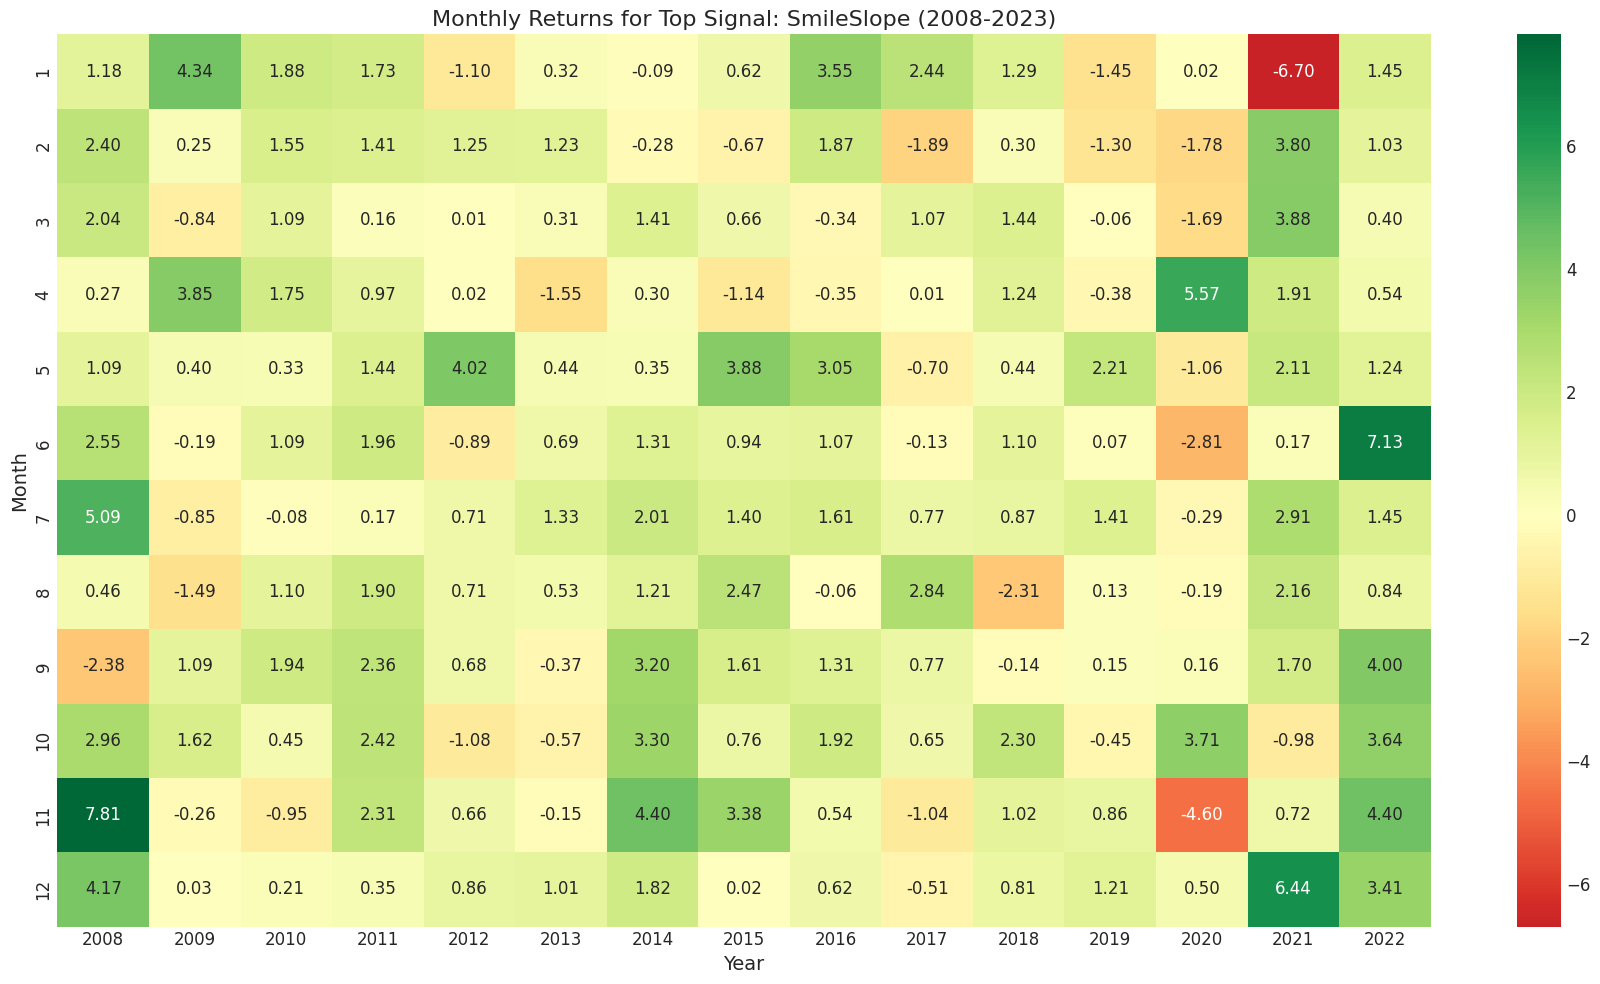

In [26]:
# 3.4 Heatmap of monthly returns for top 5 signals
plt.figure(figsize=(18, 10))
monthly_pivot = ls_returns.copy()
monthly_pivot['year'] = monthly_pivot['date'].dt.year
monthly_pivot['month'] = monthly_pivot['date'].dt.month
top_5_monthly = monthly_pivot.pivot_table(index='month', columns='year', values=top_5_signals[0])

sns.heatmap(top_5_monthly, cmap='RdYlGn', center=0, annot=True, fmt='.2f')
plt.title(f'Monthly Returns for Top Signal: {top_5_signals[0]} (2008-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.tight_layout()
plt.show()  # Display in notebook instead of saving to file

**Step 4: Pre-COVID vs Post-COVID**

In [27]:
covid_cutoff = pd.Timestamp('2020-01-01')
pre_covid = ls_returns_indexed[ls_returns_indexed.index < covid_cutoff]
post_covid = ls_returns_indexed[ls_returns_indexed.index >= covid_cutoff]


In [28]:
print(f"Pre-COVID period: {pre_covid.index.min()} to {pre_covid.index.max()}")
print(f"Post-COVID period: {post_covid.index.min()} to {post_covid.index.max()}")

Pre-COVID period: 2008-01-31 00:00:00 to 2019-12-31 00:00:00
Post-COVID period: 2020-01-31 00:00:00 to 2022-12-30 00:00:00


In [29]:
# Calculate statistics for pre and post COVID
pre_covid_monthly_mean = pre_covid.mean()
post_covid_monthly_mean = post_covid.mean()

In [30]:
# Only calculate annualized returns for signals with sufficient data
valid_pre_covid = ~pre_covid_monthly_mean.isna()
valid_post_covid = ~post_covid_monthly_mean.isna()
valid_both = valid_pre_covid & valid_post_covid

In [31]:
pre_covid_ann_return = pre_covid_monthly_mean.copy()
post_covid_ann_return = post_covid_monthly_mean.copy()


In [32]:
# Annualize returns only for valid data
pre_covid_ann_return[valid_pre_covid] = ((1 + pre_covid_monthly_mean[valid_pre_covid]) ** 12) - 1
post_covid_ann_return[valid_post_covid] = ((1 + post_covid_monthly_mean[valid_post_covid]) ** 12) - 1

In [33]:
covid_comparison = pd.DataFrame({
    'Pre_COVID_Ann_Return': pre_covid_ann_return,
    'Post_COVID_Ann_Return': post_covid_ann_return,
    'Return_Difference': post_covid_ann_return - pre_covid_ann_return
})

In [34]:
# Filter to keep only signals with data in both periods
covid_comparison_valid = covid_comparison[valid_both]

In [35]:
# Sort by difference in returns
covid_comparison_sorted = covid_comparison_valid.sort_values('Return_Difference', ascending=False)

In [36]:
# Display top signals that improved post-COVID
print(f"\nTop 10 signals with biggest improvement post-COVID (out of {len(covid_comparison_sorted)} signals with data in both periods):")


Top 10 signals with biggest improvement post-COVID (out of 204 signals with data in both periods):


In [37]:
# Format the dataframe for better readability
pd.set_option('display.float_format', '{:.2e}'.format)  # Use scientific notation for extreme values

In [38]:
# Create a copy of the dataframe
covid_readable = covid_comparison_sorted.head(20).copy()  # Get top 20 to select from after sorting by relative change

In [39]:
# Add percentage change column for clearer comparison
covid_readable['Percentage_Change_Numeric'] = np.nan  # Default value for numeric sorting
covid_readable['Percentage_Change'] = 'N/A'  # Default value for display

# Calculate percentage change where possible (avoiding division by zero)
for idx, row in covid_readable.iterrows():
    pre = row['Pre_COVID_Ann_Return']
    post = row['Post_COVID_Ann_Return']
    
    if pre != 0 and not np.isnan(pre) and not np.isnan(post):
        pct_change = ((post - pre) / abs(pre)) * 100
        covid_readable.at[idx, 'Percentage_Change_Numeric'] = pct_change
        covid_readable.at[idx, 'Percentage_Change'] = f"{pct_change:.2f}%"
    elif pre == 0 and post > 0:
        covid_readable.at[idx, 'Percentage_Change_Numeric'] = float('inf')
        covid_readable.at[idx, 'Percentage_Change'] = "∞"  # Infinity symbol for change from zero
    elif pre == 0 and post < 0:
        covid_readable.at[idx, 'Percentage_Change_Numeric'] = float('-inf')
        covid_readable.at[idx, 'Percentage_Change'] = "-∞"  # Negative infinity 
    elif pre == 0 and post == 0:
        covid_readable.at[idx, 'Percentage_Change_Numeric'] = 0
        covid_readable.at[idx, 'Percentage_Change'] = "0.00%"

# Add a direction column
covid_readable['Direction'] = ['Negative to Positive' if (row['Pre_COVID_Ann_Return'] < 0 and row['Post_COVID_Ann_Return'] > 0) 
                             else 'Positive to Negative' if (row['Pre_COVID_Ann_Return'] > 0 and row['Post_COVID_Ann_Return'] < 0)
                             else 'Improved' if row['Return_Difference'] > 0
                             else 'Deteriorated' 
                             for _, row in covid_readable.iterrows()]

# Sort by relative change (percentage) instead of absolute change
covid_readable = covid_readable.sort_values('Percentage_Change_Numeric', ascending=False).head(10)

# Reorder columns for better readability and drop the numeric column used for sorting
covid_readable = covid_readable[['Pre_COVID_Ann_Return', 'Post_COVID_Ann_Return', 'Return_Difference', 'Percentage_Change', 'Direction']]

# Rename columns for clarity
covid_readable.columns = ['Pre-COVID Return', 'Post-COVID Return', 'Absolute Change', 'Relative Change', 'Direction']

# Display the table
print(covid_readable)

                 Pre-COVID Return  Post-COVID Return  Absolute Change  \
MomVol                  -7.21e-01           9.11e+09         9.11e+09   
MomOffSeason            -9.87e-02           9.97e+06         9.97e+06   
MomRev                  -9.99e-01           9.09e+07         9.09e+07   
IntanSP                 -1.74e-01           1.14e+06         1.14e+06   
BM                      -1.00e+00           3.04e+06         3.04e+06   
ChNAnalyst               1.03e+04           4.66e+09         4.66e+09   
EarnSupBig               2.58e+00           1.08e+06         1.08e+06   
Mom12mOffSeason          6.77e+01           8.64e+06         8.64e+06   
ChEQ                     5.12e+00           4.13e+05         4.13e+05   
SP                       1.07e+02           7.03e+06         7.03e+06   

                   Relative Change             Direction  
MomVol           1263715951358.76%  Negative to Positive  
MomOffSeason       10100235316.03%  Negative to Positive  
MomRev             

In [40]:
# Display signals that deteriorated most post-COVID
print(f"\nTop 10 signals with biggest deterioration post-COVID (out of {len(covid_comparison_sorted)} signals with data in both periods):")

# Create a copy of the dataframe
covid_readable_worst = covid_comparison_sorted.tail(20).copy()  # Get bottom 20 to select from after sorting

# Add percentage change column for clearer comparison
covid_readable_worst['Percentage_Change_Numeric'] = np.nan  # Default value for numeric sorting
covid_readable_worst['Percentage_Change'] = 'N/A'  # Default value for display

# Calculate percentage change where possible (avoiding division by zero)
for idx, row in covid_readable_worst.iterrows():
    pre = row['Pre_COVID_Ann_Return']
    post = row['Post_COVID_Ann_Return']
    
    if pre != 0 and not np.isnan(pre) and not np.isnan(post):
        pct_change = ((post - pre) / abs(pre)) * 100
        covid_readable_worst.at[idx, 'Percentage_Change_Numeric'] = pct_change
        covid_readable_worst.at[idx, 'Percentage_Change'] = f"{pct_change:.2f}%"
    elif pre == 0 and post > 0:
        covid_readable_worst.at[idx, 'Percentage_Change_Numeric'] = float('inf')
        covid_readable_worst.at[idx, 'Percentage_Change'] = "∞"  # Infinity symbol for change from zero
    elif pre == 0 and post < 0:
        covid_readable_worst.at[idx, 'Percentage_Change_Numeric'] = float('-inf')
        covid_readable_worst.at[idx, 'Percentage_Change'] = "-∞"  # Negative infinity 
    elif pre == 0 and post == 0:
        covid_readable_worst.at[idx, 'Percentage_Change_Numeric'] = 0
        covid_readable_worst.at[idx, 'Percentage_Change'] = "0.00%"

# Add a direction column
covid_readable_worst['Direction'] = ['Negative to Positive' if (row['Pre_COVID_Ann_Return'] < 0 and row['Post_COVID_Ann_Return'] > 0) 
                                  else 'Positive to Negative' if (row['Pre_COVID_Ann_Return'] > 0 and row['Post_COVID_Ann_Return'] < 0)
                                  else 'Improved' if row['Return_Difference'] > 0
                                  else 'Deteriorated' 
                                  for _, row in covid_readable_worst.iterrows()]

# Sort by relative change (percentage) and get the 10 with the worst (lowest) percentage change
covid_readable_worst = covid_readable_worst.sort_values('Percentage_Change_Numeric', ascending=True).head(10)

# Reorder columns for better readability and drop the numeric column used for sorting
covid_readable_worst = covid_readable_worst[['Pre_COVID_Ann_Return', 'Post_COVID_Ann_Return', 'Return_Difference', 'Percentage_Change', 'Direction']]

# Rename columns for clarity
covid_readable_worst.columns = ['Pre-COVID Return', 'Post-COVID Return', 'Absolute Change', 'Relative Change', 'Direction']

# Display the table
print(covid_readable_worst)


Top 10 signals with biggest deterioration post-COVID (out of 204 signals with data in both periods):
                      Pre-COVID Return  Post-COVID Return  Absolute Change  \
RD                            5.62e+01          -9.98e-01        -5.72e+01   
ShareVol                      1.21e+02          -1.00e+00        -1.22e+02   
zerotrade                     1.39e+02          -1.00e+00        -1.40e+02   
NetDebtPrice                  1.65e+02          -9.68e-01        -1.66e+02   
zerotradeAlt1                 1.84e+02          -9.95e-01        -1.85e+02   
OptionVolume1                 1.97e+02          -4.42e-01        -1.98e+02   
Recomm_ShortInterest          5.89e+02          -7.02e-01        -5.90e+02   
PS                            5.81e+03          -1.00e+00        -5.81e+03   
IndRetBig                     8.09e+02          -1.35e-01        -8.09e+02   
IntMom                        2.02e+03           5.68e+00        -2.01e+03   

                     Relative Change   

In [41]:
# Also show signals with missing data
missing_data = covid_comparison[~valid_both]
if not missing_data.empty:
    print(f"\nSignals with insufficient data for COVID comparison ({len(missing_data)} total):")
    missing_pre = missing_data[missing_data['Pre_COVID_Ann_Return'].isna()]
    missing_post = missing_data[missing_data['Post_COVID_Ann_Return'].isna()]
    
    if not missing_pre.empty:
        print(f"  - Missing pre-COVID data: {len(missing_pre)} signals")
    if not missing_post.empty:
        print(f"  - Missing post-COVID data: {len(missing_post)} signals")



Signals with insufficient data for COVID comparison (8 total):
  - Missing pre-COVID data: 3 signals
  - Missing post-COVID data: 8 signals


**Step 5: Correlation among top signals**

In [42]:
top_10_signals = summary_stats_sorted.index[:10]
correlation_matrix = ls_returns_indexed[top_10_signals].corr()

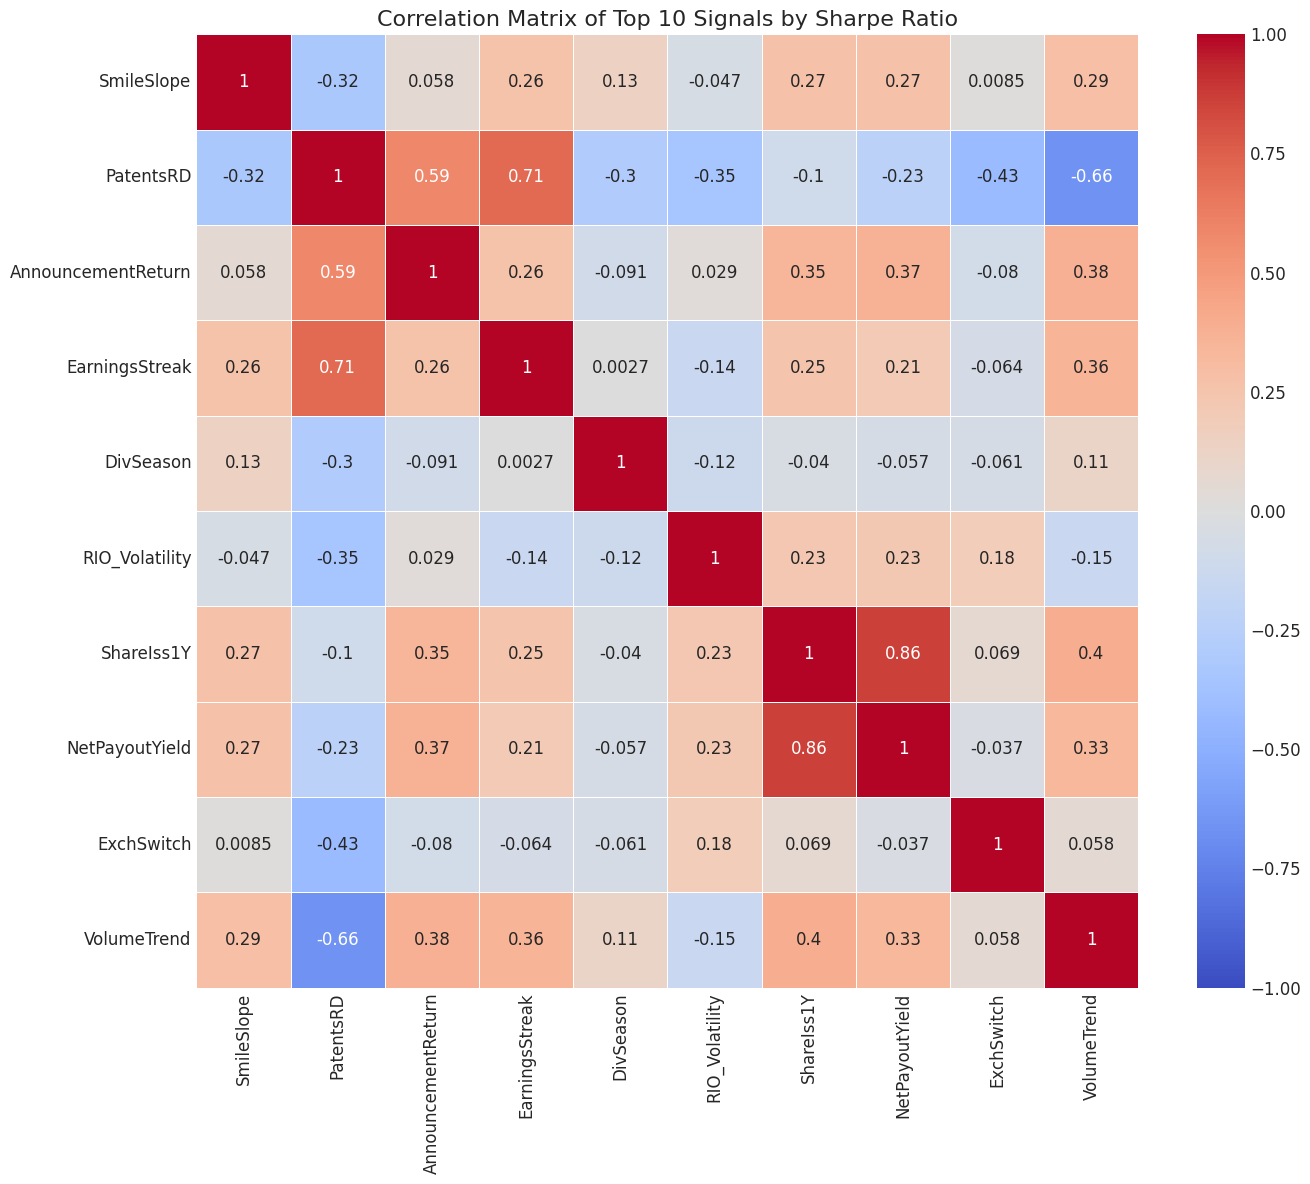

In [43]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Top 10 Signals by Sharpe Ratio', fontsize=16)
plt.tight_layout()
plt.show()  # Display in notebook instead of saving to file

**Step 6: Crisis vs Boom Analysis**

In [44]:
# Define some crisis periods
crisis_periods = {
    'Global Financial Crisis': ('2008-01-01', '2009-06-30'),
    'European Debt Crisis': ('2010-04-01', '2012-06-30'),
    'COVID-19 Crisis': ('2020-02-01', '2020-04-30'),
    'Inflation Crisis': ('2022-01-01', '2022-12-31')
}


In [45]:
# Create a dataset with just the top 10 signals
top_signals = summary_stats_sorted.index[:10]
top_signals_returns = ls_returns_indexed[top_signals]

In [46]:
# Calculate performance during different periods
period_performance = {}

for period_name, (start_date, end_date) in crisis_periods.items():
    print(f"\nAnalyzing {period_name} ({start_date} to {end_date})...")
    
    # Get data for this period
    try:
        period_data = top_signals_returns.loc[start_date:end_date]
        print(f"  Found {len(period_data)} observations in this period")
        
        if len(period_data) > 0:
            # Calculate monthly mean returns
            monthly_mean = period_data.mean()
            
            # Convert to annualized returns
            annualized_return = monthly_mean * 12  # Simple annualization to avoid extreme compounding
            
            # Store results
            period_performance[period_name] = annualized_return
        else:
            print(f"  No data available for {period_name}")
            # Fill with NaN if no data available
            period_performance[period_name] = pd.Series(np.nan, index=top_signals)
    except Exception as e:
        print(f"  Error analyzing {period_name}: {e}")
        period_performance[period_name] = pd.Series(np.nan, index=top_signals)

# Convert to DataFrame for easy viewing
period_df = pd.DataFrame(period_performance)

# Add the overall performance for comparison
period_df['Overall'] = summary_stats.loc[top_signals, 'Ann_Return']

# Print the crisis period performance with better formatting
print("\nPerformance of top signals during crisis periods (annualized returns):")

# Format the DataFrame for better readability
pd.set_option('display.float_format', '{:.2f}'.format)  # Use 2 decimal places
print(period_df.fillna("N/A"))  # Replace NaN with N/A for cleaner display



Analyzing Global Financial Crisis (2008-01-01 to 2009-06-30)...
  Found 18 observations in this period

Analyzing European Debt Crisis (2010-04-01 to 2012-06-30)...
  Found 27 observations in this period

Analyzing COVID-19 Crisis (2020-02-01 to 2020-04-30)...
  Found 3 observations in this period

Analyzing Inflation Crisis (2022-01-01 to 2022-12-31)...
  Found 12 observations in this period

Performance of top signals during crisis periods (annualized returns):
                    Global Financial Crisis European Debt Crisis  \
SmileSlope                            23.63                11.70   
PatentsRD                              8.03                  N/A   
AnnouncementReturn                    -2.10                17.28   
EarningsStreak                         9.11                 6.75   
DivSeason                              9.39                 1.06   
RIO_Volatility                         0.85                13.11   
ShareIss1Y                             6.57            

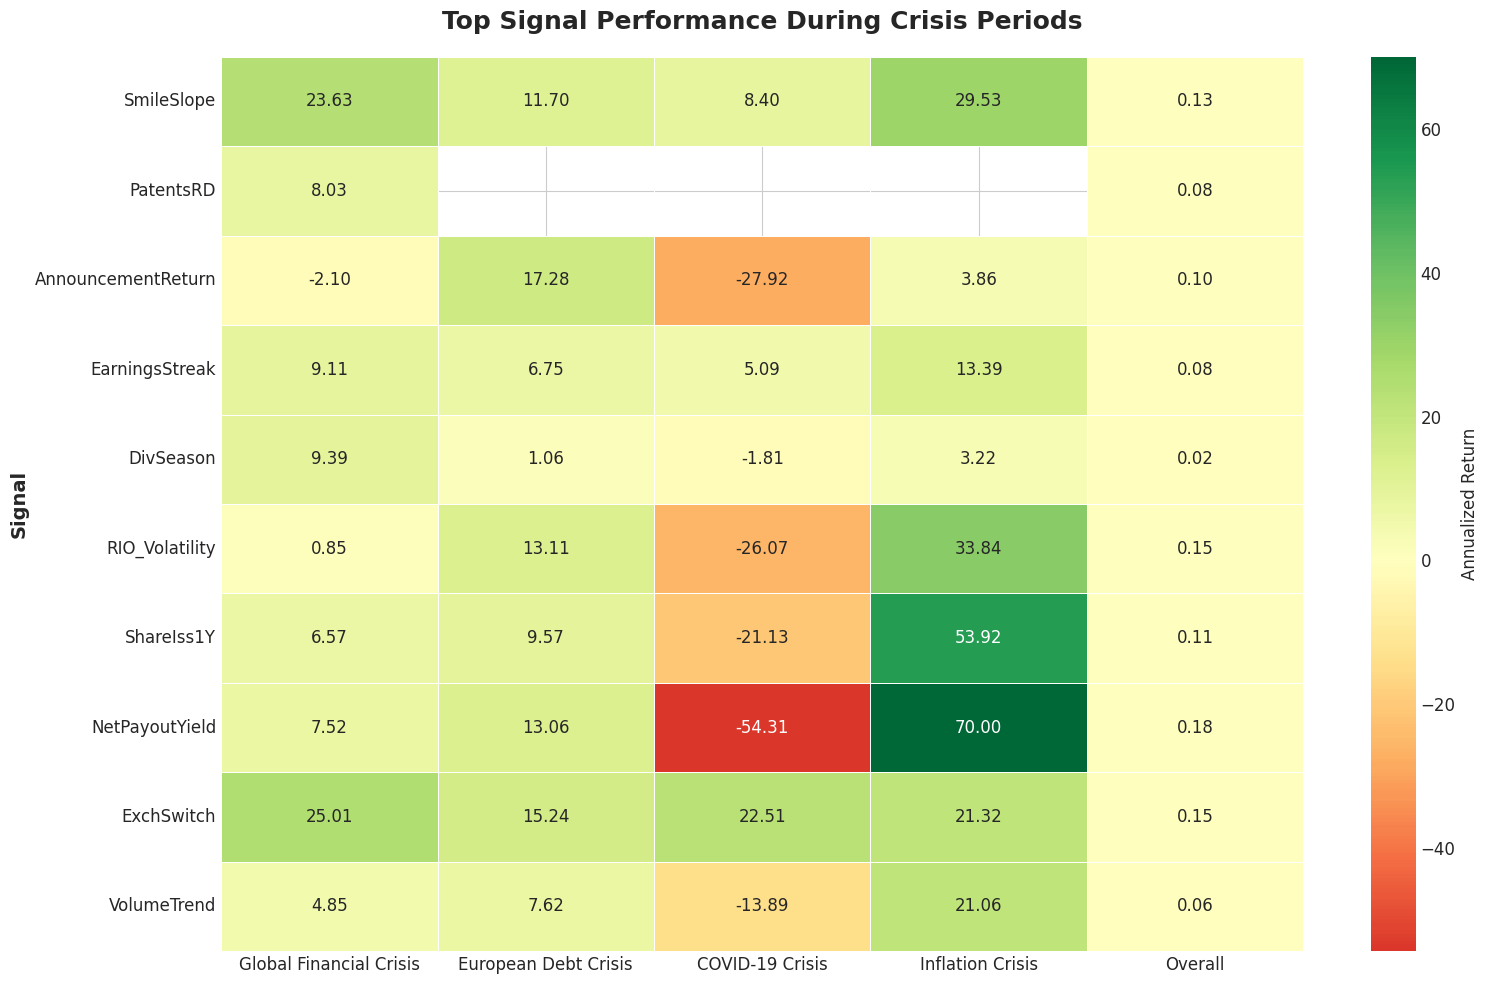

In [47]:
# Create a heatmap visualization of crisis performance
plt.figure(figsize=(16, 10))
sns.heatmap(period_df, cmap='RdYlGn', center=0, annot=True, fmt='.2f', 
            linewidths=0.5, cbar_kws={'label': 'Annualized Return'})
plt.title('Top Signal Performance During Crisis Periods', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Signal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()  

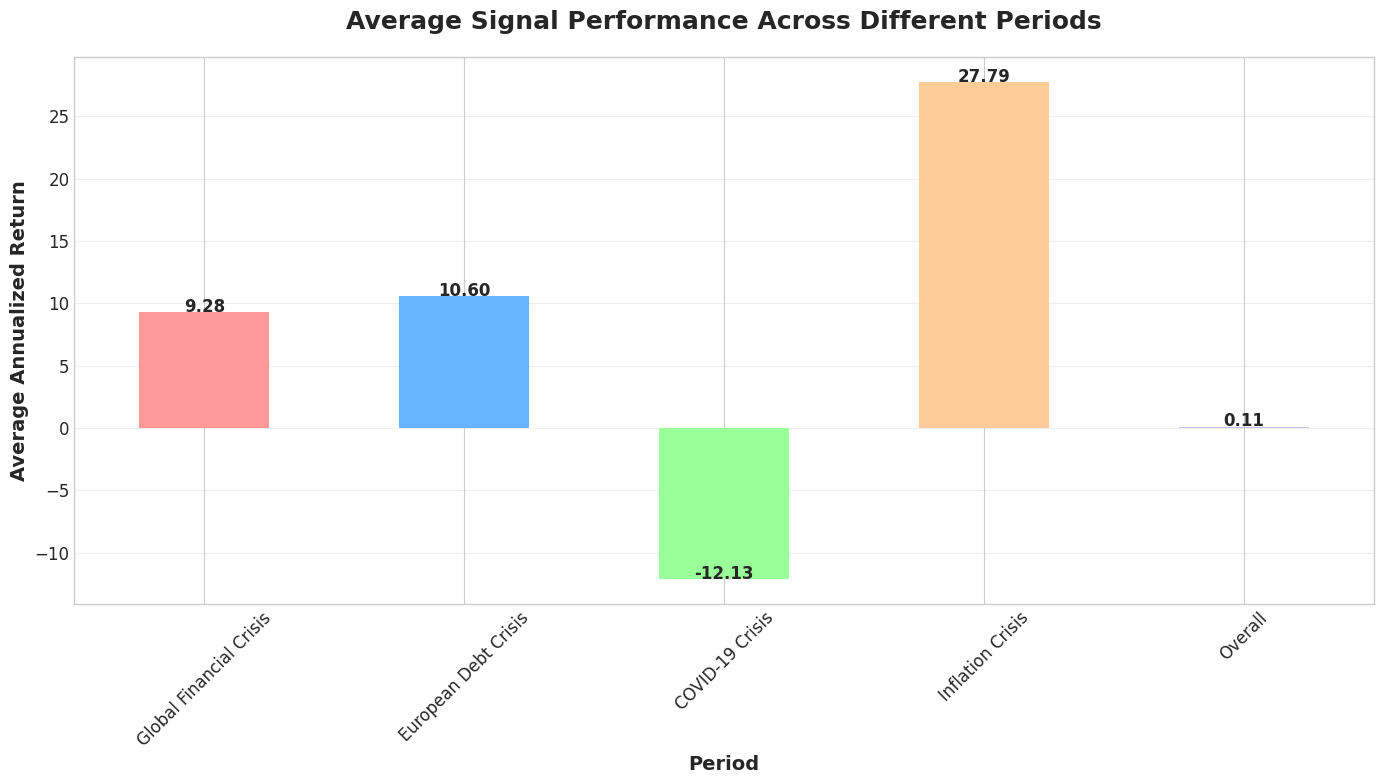

In [48]:
# Also create a bar chart comparing average performance across periods
plt.figure(figsize=(14, 8))
period_means = period_df.mean()
period_means.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Average Signal Performance Across Different Periods', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Average Annualized Return', fontsize=14, fontweight='bold')
plt.xlabel('Period', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(period_means):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show() 

**Step 7: Summary of Findings** 

In [49]:
# 7. Summary of findings

print("\n===== SUMMARY OF FINDINGS =====")
print(f"Analysis period: {ls_returns_indexed.index.min().strftime('%Y-%m-%d')} to {ls_returns_indexed.index.max().strftime('%Y-%m-%d')}")
print(f"Total number of signals analyzed: {ls_returns_indexed.shape[1]}")

# Handle possibility of empty sorted dataframe
if not summary_stats_sorted.empty:
    best_signal = summary_stats_sorted.index[0]
    best_return = summary_stats_sorted['Ann_Return'][0]
    best_sharpe = summary_stats_sorted['Ann_Sharpe'][0]
    
    print(f"Best performing signal by annualized return: {best_signal} ({best_return*100:.2f}%)")
    print(f"Best performing signal by Sharpe ratio: {best_signal} ({best_sharpe:.2f})")
    print("\nTop 5 signals by Sharpe ratio:")
    
    for i, signal in enumerate(summary_stats_sorted.index[:5], 1):
        print(f"{i}. {signal}: Return = {summary_stats_sorted['Ann_Return'][signal]*100:.2f}%, Sharpe = {summary_stats_sorted['Ann_Sharpe'][signal]:.2f}")
else:
    print("No signals found with complete data for analysis period.")


===== SUMMARY OF FINDINGS =====
Analysis period: 2008-01-31 to 2022-12-30
Total number of signals analyzed: 212
Best performing signal by annualized return: SmileSlope (12.69%)
Best performing signal by Sharpe ratio: SmileSlope (1.99)

Top 5 signals by Sharpe ratio:
1. SmileSlope: Return = 12.69%, Sharpe = 1.99
2. PatentsRD: Return = 8.33%, Sharpe = 1.42
3. AnnouncementReturn: Return = 9.58%, Sharpe = 1.42
4. EarningsStreak: Return = 7.57%, Sharpe = 1.17
5. DivSeason: Return = 1.97%, Sharpe = 1.05
